In [88]:
import xarray as xr
from matplotlib import pylab as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
import pandas as pd
import bed_and_nn_functions as fnb
from matplotlib import colors
CREATE =False

In [2]:
def border_cell_on_icesheet(mask):
    """mask is interger 2d-array"""
    #### creating boarder cells in on the antartic ice sheet, e.g. last grounded cell
    boarder_mask = np.zeros(mask.shape)
    difm =mask[1:,:] - mask[:-1,:]
    m_1 = difm ==1
    m_minus1 = difm == -1
    boarder_mask[1:,][m_1]=1
    boarder_mask[:-1,][m_minus1]=1

    difu = mask[:,1:] - mask[:,:-1]
    m_1u = difu ==1
    m_minus1u = difu == -1
    boarder_mask[:,1:][m_1u]=1
    boarder_mask[:,:-1][m_minus1u]=1
    return(boarder_mask)

def border_cell_outside_icesheet(mask):

    #### creating boarder cells  around antartic ice sheet, e.g. first floating cell or open ocean
    boarder_mask_float = np.zeros(mask.shape)
    difm =mask[1:,:] - mask[:-1,:]
    m_1 = difm ==1
    m_minus1 = difm == -1
    boarder_mask_float[:-1,][m_1]=1
    boarder_mask_float[1:,][m_minus1]=1

    difu = mask[:,1:] - mask[:,:-1]
    m_1u = difu ==1
    m_minus1u = difu == -1
    boarder_mask_float[:,:-1][m_1u]=1
    boarder_mask_float[:,1:][m_minus1u]=1
    return boarder_mask_float

In [3]:
d = xr.open_dataset('./../Data/Fields/friction_coefficient.nc')

d2 = xr.open_dataset('./../Data/Fields/mask_grounded.nc')
d2['mask_grounded']
d3 = xr.open_dataset('./../Data/Fields/basin.nc')
d4 = xr.open_dataset('./../Data/Fields/bed.nc')
bd = d4['bed'].values
d5 = xr.open_dataset('./../Data/Fields/thickness.nc')
d6 = xr.open_dataset('./../Data/Fields/geothermalflux.nc')
d7 = xr.open_dataset('./../Data/Fields/bedtype.nc')
if CREATE:
    slopes_angle_ana =fnb.create_bed_slope_angle(d4)
else:
    d8 = xr.open_dataset('./../Data/Fields/bedslope.nc')
    slopes_angle_ana =d8.bed_slope.values
m_fl = d2['mask_grounded'].values <0
#  friction ony grounded :
gr=d['friction_c'].values.copy() 
gr[m_fl] = np.nan
# creating nearest nieghbour mean friction coefficient
if CREATE:
    friction_nn,strings =fnb.nnmean_skipnan(gr)
    friction_nn.dump('./../Data/Fields/friction_nnmean_onlygrounded')
else:
    friction_nn =np.load('./../Data/Fields/friction_nnmean_onlygrounded',allow_pickle=True)

### we know that pig retreat approxmatley 60km lets us just work with 60 iterration of retreat, creating nans:

In [4]:
### calulated new coefficent along the boarder
## then fill in new values and created new boarder , 
# continue until there are no more nans
   
    
c_retreat = gr.copy()
# xmin_a,xmax_a,ymin_a,ymax_a = fnb.window3x3_a(c_retreat)
##################################################################
for i in range(60):
    mask=(~ np.isnan(c_retreat)).astype('int')
    boarder_mask = border_cell_on_icesheet(mask)
    x_list,y_list =np.where(boarder_mask ==1)
    c_retreat[x_list,y_list] =np.nan
# notnans = np.zeros(len(x_list))
# vals = np.zeros(len(x_list))
# for i in range(len(x_list)):
#     vals[i],notnans[i],check = fnb.nnmean__numbernotnans_ax_ay(c_floating,y_list[i],x_list[i],xmin_a,xmax_a,ymin_a,ymax_a)
   
#     c_floating[x_list[start],y_list[start]] =vals[start]
#     print('was running ',str(i))

# # for i in range(len(x_list)):

# #         val,check = fnb.nnmean_ax_ay(c_floating,y_list[i],x_list[i],xmin_a,xmax_a,ymin_a,ymax_a)
# #         c_floating[x_list[i],y_list[i]] =val
# #     print('was runing ',str(i))

# np.save('./../Data/Fields/new_friction_weight.npy',c_floating)



(1500.0, 2300.0)

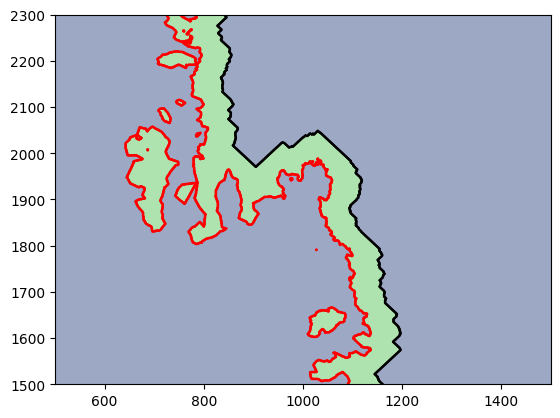

In [5]:
xmin,xmax,ymin,ymax=500,1500,1500,2300
# get the diff mask
mask_r=(~ np.isnan(c_retreat)).astype('int')
mask_gr=(~ np.isnan(gr)).astype('int')
mask_diff = mask_gr -mask_r
f,ax = plt.subplots(1,1)
ax.contourf(d.x,d.y,mask_diff,origin ='lower',alpha = 0.5,levels=[-0.5,0.5,1.5] )

ax.contour(d.x,d.y,np.isnan(c_retreat).astype('int'),origin ='lower',alpha = 0.5,colors = 'black' )
ax.contour(d.x,d.y,np.isnan(gr).astype('int'),origin ='lower',alpha = 0.5,colors = 'red')
ax.set_xlim([xmin,xmax])
ax.set_ylim([ymin,ymax])

In [80]:
np.isnan(c_floating[mask_diff.astype('bool')]).sum()

0

## now let us create the nn and wnumber of neighbours that are not nan

In [90]:
### calulated new coefficent along the boarder
## then fill in new values and created new boarder , 
# continue until there are no more nans
if CREATE:   
    
    c_floating = c_retreat.copy()
    weights = np.zeros(c_floating.shape)
    weights_adapt = np.zeros(c_floating.shape)

    xmin_a,xmax_a,ymin_a,ymax_a = fnb.window3x3_a(c_floating)
    ##################################################################

    while np.isnan(c_floating[mask_diff.astype('bool')]).sum() >0:
        mask=(~ np.isnan(c_floating)).astype('int')
        boarder_mask = border_cell_outside_icesheet(mask)
        x_list,y_list =np.where(boarder_mask ==1)
        notnans = np.zeros(len(x_list))
        notnans_adapt = np.zeros(len(x_list))

        vals = np.zeros(len(x_list))
        vals_wrong = np.zeros(len(x_list))

        for i in range(len(x_list)):
            vals[i],notnans_adapt[i],check = fnb.nnmean__numbernotnans_ax_ay(c_floating,y_list[i],x_list[i],xmin_a,xmax_a,ymin_a,ymax_a)
            vals_wrong[i],notnans[i],check = fnb.nnmean__numbernotnans_ax_ay(c_retreat,y_list[i],x_list[i],xmin_a,xmax_a,ymin_a,ymax_a)
        #get cells with most neighbours not nans
        weights[x_list,y_list] =notnans

        start = notnans_adapt ==notnans_adapt.max() 
        c_floating[x_list[start],y_list[start]] =vals[start]
        weights_adapt[x_list[start],y_list[start]] =notnans_adapt[start]
    np.save('./../Data/Fields/artifical_grounded_friction.npy',c_retreat)
    np.save('./../Data/Fields/artifical_new_friction.npy',c_floating)

    np.save('./../Data/Fields/artifial_weights_fromgrouned.npy ',weights)
    np.save('./../Data/Fields/artifial_weights_fromnn.npy',weights_adapt)
else:
    c_retreat=np.load('./../Data/Fields/artifical_grounded_friction.npy')
    c_floating =np.load('./../Data/Fields/artifical_new_friction.npy')

    weights =np.load('./../Data/Fields/artifical_weights_fromgrouned.npy')

    weights_adapt =np.load('./../Data/Fields/artifical_weights_fromnn.npy')

    #     print('was running ',str(i))


    # for i in range(len(x_list)):

    #         val,check = fnb.nnmean_ax_ay(c_floating,y_list[i],x_list[i],xmin_a,xmax_a,ymin_a,ymax_a)
    #         c_floating[x_list[i],y_list[i]] =val
    #     print('was runing ',str(i))

    # np.save('./../Data/Fields/new_friction_weight.npy',c_floating)


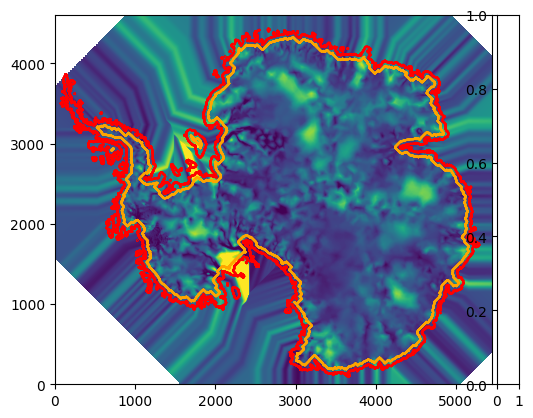

In [158]:
f,ax = plt.subplots(1,1)
divider = make_axes_locatable(ax)
im =ax.imshow(c_floating,vmin=0,vmax=500,origin ='lower')

cax = divider.append_axes('right', size='5%', pad=0.05)
mask_gl=(~ np.isnan(gr)).astype('int')
mask_r=(~ np.isnan(c_retreat)).astype('int')
mask_extent = ~np.isnan(d2['mask_grounded'].values)
ax.contour(d2.x,d2.y,mask_gl,colors = 'red')
ax.contour(d2.x,d2.y,mask_r,colors = 'orange')

In [184]:
d_nn = d.copy()
mnan=np.isnan(c_floating)
fillval = np.nanmean(c_floating)
c_floating[mnan]=fillval
d_nn['friction_c'].values = c_floating
d_nn.to_netcdf('./../Data/Fields/friction_coefficient_nn.nc')

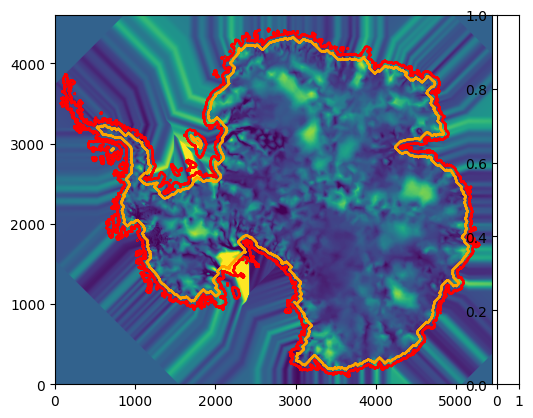

In [185]:
f,ax = plt.subplots(1,1)
divider = make_axes_locatable(ax)
im =ax.imshow(c_floating,vmin=0,vmax=500,origin ='lower')

cax = divider.append_axes('right', size='5%', pad=0.05)
mask_gl=(~ np.isnan(gr)).astype('int')
mask_r=(~ np.isnan(c_retreat)).astype('int')
mask_extent = ~np.isnan(d2['mask_grounded'].values)
ax.contour(d2.x,d2.y,mask_gl,colors = 'red')
ax.contour(d2.x,d2.y,mask_r,colors = 'orange')

In [174]:
mask_retreat = mask_r.copy()
mask_retreat=mask_retreat.astype('float')
mask_retreat[mask_retreat==0]=np.nan
d_retreat = d2.copy()
d_retreat['mask_grounded'].values = mask_retreat
d_retreat.to_netcdf('./../Data/Fields/retreated_mask_grounded.nc')


In [183]:
mask_retreat = mask_diff.copy()
mask_retreat=mask_retreat.astype('float')
mask_retreat[mask_retreat==0]=np.nan
d_retreat = d2.copy()
d_retreat['mask_grounded'].values = mask_retreat
d_retreat.rename({'mask_grounded': 'mask_change'})
d_retreat.to_netcdf('./../Data/Fields/retreated_diff_mask_grounded.nc')
# geotiff_ds.rename({1: 'bedtype'})

In [182]:
d_retreat


<xarray.Dataset>
Dimensions:        (y: 4608, x: 5448)
Dimensions without coordinates: y, x
Data variables:
    mask_grounded  (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan

In [180]:
d_retr


<xarray.DataArray 'mask_grounded' (y: 4608, x: 5448)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Dimensions without coordinates: y, x

In [173]:
np.unique(mask_retreat)

array([ 1., nan])

In [ ]:
make weight intersio nan, as we took real issm values then create a weighted matrix

In [91]:
weights_adapt[mask_r.astype('bool')] = np.nan
weights_adapt[np.isnan(c_floating)] = np.nan



weights_adapt = weights_adapt +1
weights[mask_r.astype('bool')] = np.nan
weights[np.isnan(c_floating)] = np.nan

weights = weights +1
ww =weights_adapt*weights
l1 = np.unique(ww)[:-1]
l1 =l1 -0.5
last = l1[-1]+1
levels = l1.tolist()
levels.append(last)
vals = np.unique(ww)[:-1]

/var/folders/ph/m61jd3r90t190p6qvbps3yqct2hr65/T/ipykernel_3265/2702227999.py:15: UserWarning: The following kwargs were not used by contour: 'ticks', 'boundaries', 'spacing', 'format'
  im = ax.contourf(d2.x,d2.y,ww,cmap =cmap,norm =norm,ticks=bounds, boundaries=bounds,spacing='proportional',format='%1i' )


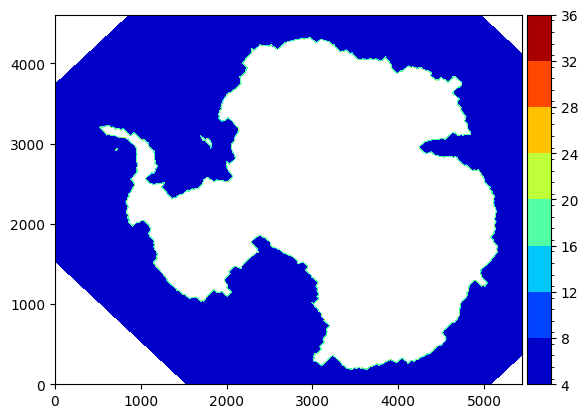

In [103]:
f,ax = plt.subplots(1,1)
divider = make_axes_locatable(ax)
# cmap = colors.ListedColormap(['blue','brown','pink','green','red','purple','gray','cyan','orange','lime','navy','lightcoral','tan'])
cmap = plt.cm.jet  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5, .5, .5, 1.0)
bounds = levels
bounds = np.arange(3.5,36.5)

norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
im = ax.contourf(d2.x,d2.y,ww,cmap =cmap,norm =norm,ticks=bounds, boundaries=bounds,spacing='proportional',format='%1i' )
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im, cax=cax, orientation='vertical')

In [140]:
c_nn_diffmask = c_floating.copy()
c_nn_diffmask[mask_diff ==0]=np.nan
c_gr_diffmask = gr.copy()
c_gr_diffmask[mask_diff ==0]=np.nan
dic ={}
gth = d6['geothermalflux'].values.copy()
dic['coefficient']= c_gr_diffmask[ mask_diff.astype('bool')]
dic['sim_coefficient']= c_nn_diffmask[ mask_diff.astype('bool')]
    
dic['bed']=bd[mask_diff .astype('bool')]
dic['slope']=slopes_angle_ana[ mask_diff.astype('bool')]
dic['gth']=gth[mask_diff .astype('bool')]
    
ds = pd.DataFrame.from_dict(dic)
ds =ds.dropna()

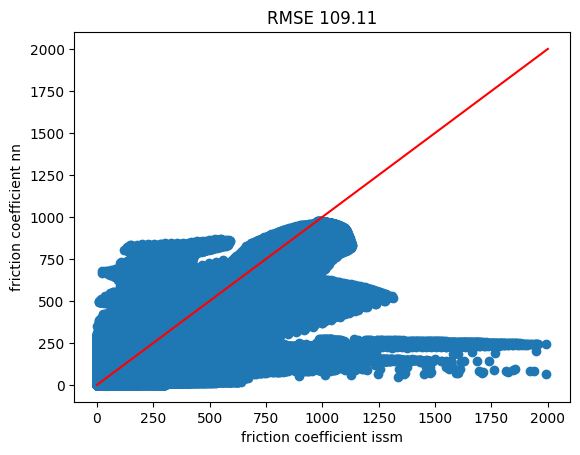

In [105]:

f,ax = plt.subplots(1,1)
ax.set_xlabel('friction coefficient issm')
ax.set_ylabel('friction coefficient nn')
c_real = c_gr_diffmask
c_sim =c_nn_diffmask
rmse = (np.nanmean((c_real-c_sim)**2))**0.5
rmse_tit = np.round(rmse,2)
ax.set_title("RMSE "+str(rmse_tit))
ax.scatter(c_real,c_sim)
ax.plot([0,2000],[0,2000], color ='red')

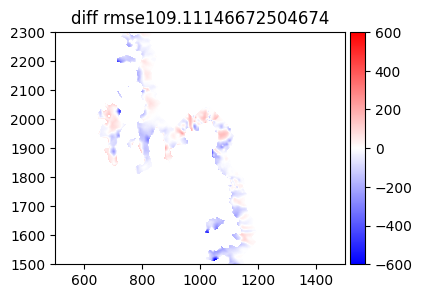

In [107]:
f,ax = plt.subplots(1,1,figsize = (4,4))
diff = c_nn_diffmask-c_gr_diffmask

im =ax.imshow(diff,origin ='lower',vmin = -600,vmax =600,cmap = mpl.colormaps['bwr'])
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
mn = np.isnan(diff)
vmin =np.nanmin(diff)
vmax =np.nanmax(diff)

rmse = (np.mean(diff[~mn]**2))**0.5


ax.set_title('diff rmse'+ str(rmse))
xmin,xmax,ymin,ymax=500,1500,1500,2300
         
ax.set_xlim([xmin,xmax])
ax.set_ylim([ymin,ymax])
f.colorbar(im, cax=cax, orientation='vertical')

In [108]:
np.nanmax(diff)

689.6029576869014

belwo and above sealevl

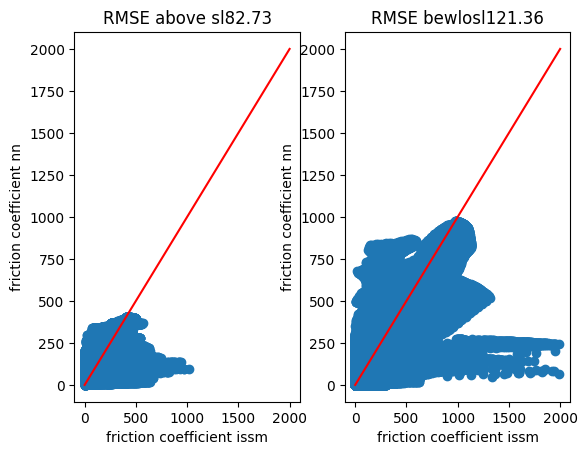

In [109]:
f,ax = plt.subplots(1,2)
ax[0].set_xlabel('friction coefficient issm')
ax[0].set_ylabel('friction coefficient nn')
ax[1].set_xlabel('friction coefficient issm')
ax[1].set_ylabel('friction coefficient nn')
c_real = c_gr_diffmask.copy()
c_sim =c_nn_diffmask.copy()
m1 =bd <0
c_real[m1]=np.nan
c_sim[m1]=np.nan

rmse = (np.nanmean((c_real-c_sim)**2))**0.5
rmse_tit = np.round(rmse,2)
ax[0].set_title("RMSE above sl"+str(rmse_tit))
ax[0].scatter(c_real,c_sim)
ax[0].plot([0,2000],[0,2000], color ='red')

c_real = c_gr_diffmask.copy()
c_sim =c_nn_diffmask.copy()
m1 =bd >0
c_real[m1]=np.nan
c_sim[m1]=np.nan

rmse = (np.nanmean((c_real-c_sim)**2))**0.5
rmse_tit = np.round(rmse,2)
ax[1].set_title("RMSE bewlosl"+str(rmse_tit))
ax[1].scatter(c_real,c_sim)
ax[1].plot([0,2000],[0,2000], color ='red')

In [111]:
len(vals)

13

### let us look at the weighting

In [114]:
c_real

array([], dtype=float64)

1
2
3
4
5
6
7
8
9
10
11
12
13


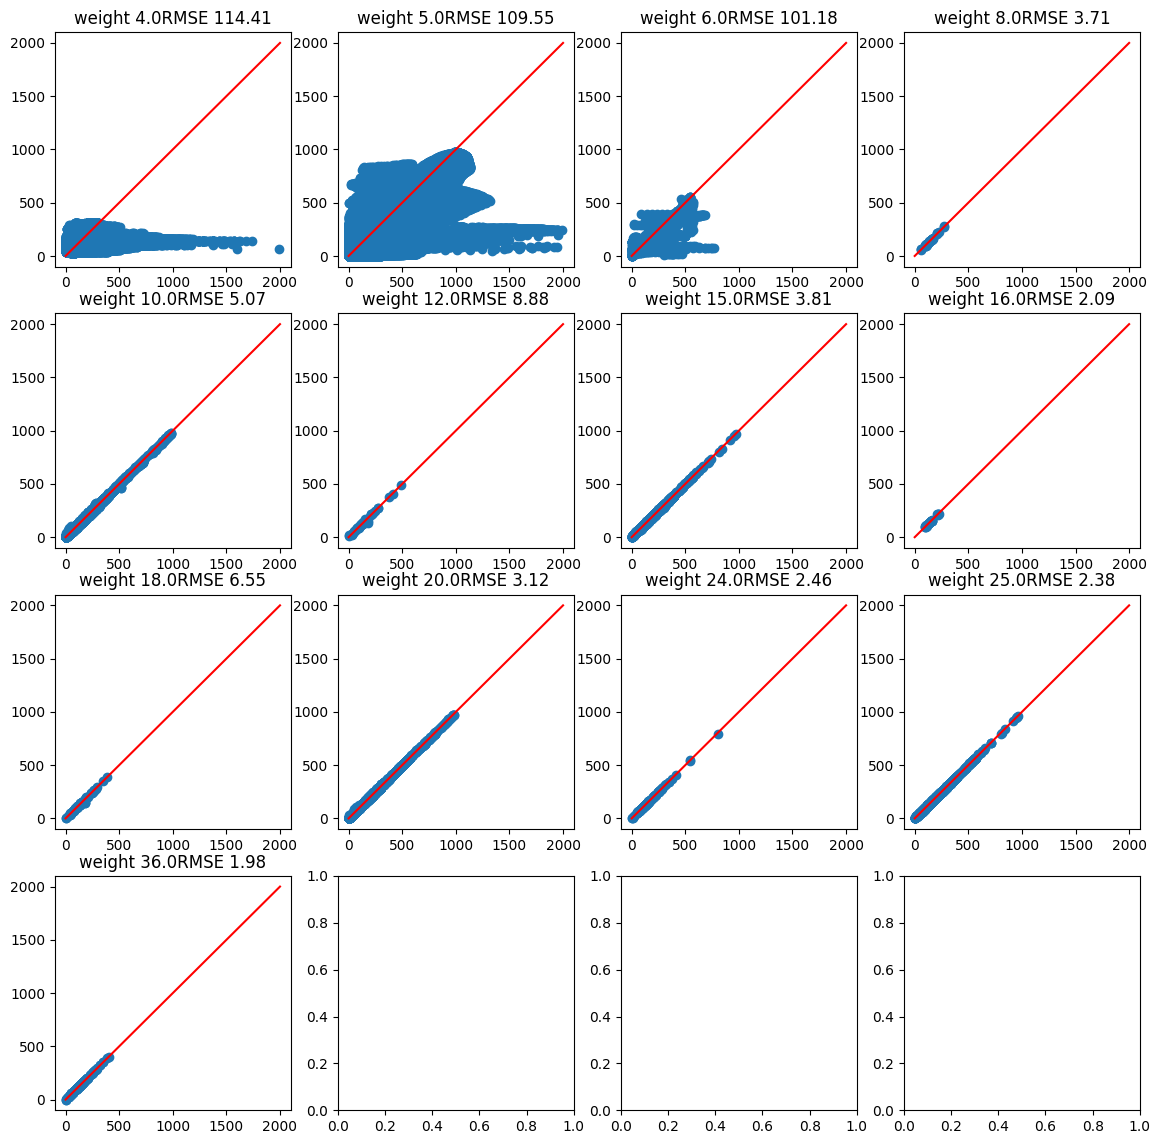

In [118]:

f, ax = plt.subplots(4,4,figsize =(14,14))
for b,val in enumerate(vals):
    i =b//4
    j = b%4
    b =b+1
    print(b)
    c_real = c_gr_diffmask.copy()
    c_sim =c_nn_diffmask.copy()
    m_b = ww == val
    c_real = c_real[m_b]
    c_sim =c_sim[m_b]
    rmse = (np.nanmean((c_real-c_sim)**2))**0.5
    rmse_tit = np.round(rmse,2)
    ax[i,j].set_title('weight '+str(val) +'RMSE '+str(rmse_tit))
    ax[i,j].scatter(c_real,c_sim)
    ax[i,j].plot([0,2000],[0,2000], color ='red')


### all goood until weight 6,5,and 4, where are they?


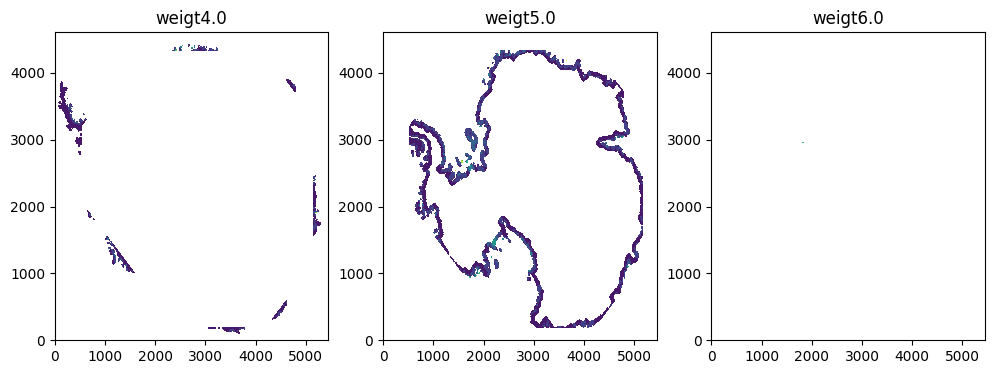

In [136]:
f, ax = plt.subplots(1,3,figsize=(12,4))
for i, val in enumerate(vals[:3]):
    c_real = c_gr_diffmask.copy()
    m_b = ww == val
    c_real[~m_b]=np.nan
    m_b =m_b.astype('float')
    m_b[m_b == 0]=np.nan
    ax[i].contourf(d2.x,d2.y,c_real,origin = 'lower')
    ax[i].set_title('weigt' +str(val))

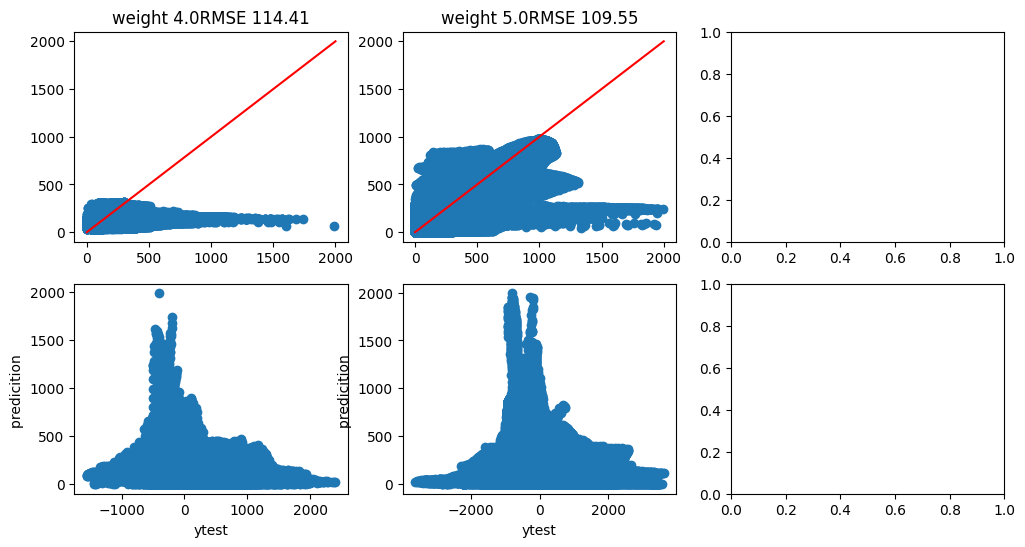

In [157]:
f, ax = plt.subplots(2,3,figsize=(12,6))
for j, val in enumerate(vals[:2]):
    c_real = c_gr_diffmask.copy()
    c_sim =c_nn_diffmask.copy()
    m_b = ww == val
    c_real[~m_b]=np.nan
    c_sim[~m_b]=np.nan
    m_neg = bd <0
    i =0
#     c_real = c_real[m_b]
#     c_sim =c_sim[m_b]
    rmse = (np.nanmean((c_real-c_sim)**2))**0.5
    rmse_tit = np.round(rmse,2)
    ax[i,j].set_title('weight '+str(val) +'RMSE '+str(rmse_tit))
    ax[i,j].scatter(c_real,c_sim)
    ax[i,j].plot([0,2000],[0,2000], color ='red')

    dic ={}
    gth = d6['geothermalflux'].values.copy()
    dic['coefficient']= c_gr_diffmask[ m_b]
    dic['sim_coefficient']= c_nn_diffmask[ m_b]
    bd_m=bd.copy()
    bd_m[~mask_diff.astype('bool')]=np.nan

    dic['bed']=bd_m[m_b]
    slope =slopes_angle_ana.copy()
    slope[~ mask_diff.astype('bool')]=np.nan
    
    
    dic['slope']=slope[m_b]
    gth_m =gth.copy()
    gth_m[~mask_diff .astype('bool')]=np.nan
    dic['gth']=gth_m[m_b]
    
    ds = pd.DataFrame.from_dict(dic)
    ds =ds.dropna()

    y = ds['coefficient']
    X = ds[['slope','bed','gth']]

    if len(ds)==0:
        continue
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=101)
    model = LinearRegression()
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    i =1
    ax[i,j].set_xlabel('ytest')
    ax[i,j].set_ylabel('predicition ')

#     c_real = y_test
#     c_sim =predictions
#     rmse = (np.nanmean((c_real-c_sim)**2))**0.5
#     rmse_tit = np.round(rmse,2)
    
#     ax[i,j].set_title('basin '+str(val) +'RMSE '+str(rmse_tit))
#     ax[i,j].scatter(c_real,c_sim)
#     ax[i,j].plot([0,2000],[0,2000], color ='red')

    ax[i,j].scatter(ds['bed'],ds['coefficient'])

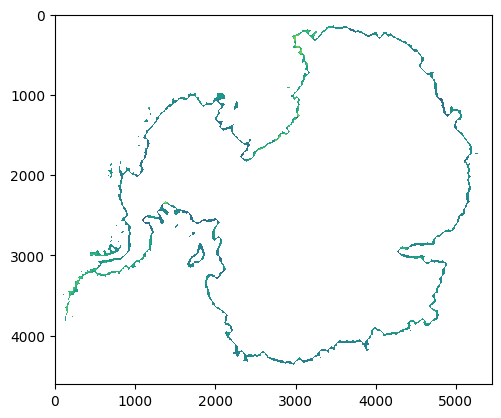

In [153]:
plt.imshow(bd_m)

In [145]:
m_b

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [75]:
np.unique(all_weights)

array([ 1.,  4.,  9., 16., 25., 36.])

In [76]:
np.unique(weights)

array([0., 1., 2., 3., 4., 5.])

In [56]:
print('done')

done


(1500.0, 2300.0)

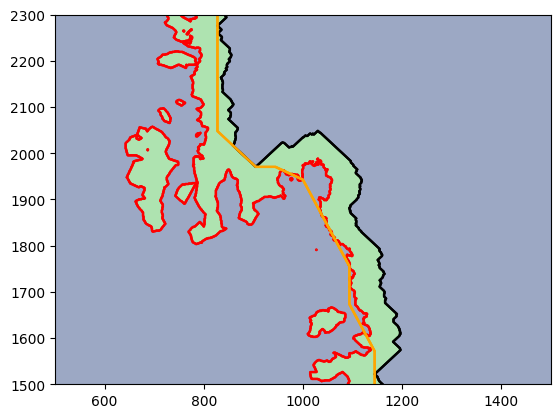

In [48]:
xmin,xmax,ymin,ymax=500,1500,1500,2300
# get the diff mask
mask_r=(~ np.isnan(c_retreat)).astype('int')
mask_gr=(~ np.isnan(gr)).astype('int')
mask_fl=(~ np.isnan(c_floating)).astype('int')

mask_diff = mask_gr -mask_r
f,ax = plt.subplots(1,1)
ax.contourf(d.x,d.y,mask_diff,origin ='lower',alpha = 0.5,levels=[-0.5,0.5,1.5] )

ax.contour(d.x,d.y,np.isnan(c_retreat).astype('int'),origin ='lower',alpha = 0.5,colors = 'black' )
ax.contour(d.x,d.y,np.isnan(gr).astype('int'),origin ='lower',alpha = 0.5,colors = 'red')
ax.contour(d.x,d.y,np.isnan(c_floating).astype('int'),origin ='lower',alpha = 0.5,colors = 'orange')
         
ax.set_xlim([xmin,xmax])
ax.set_ylim([ymin,ymax])

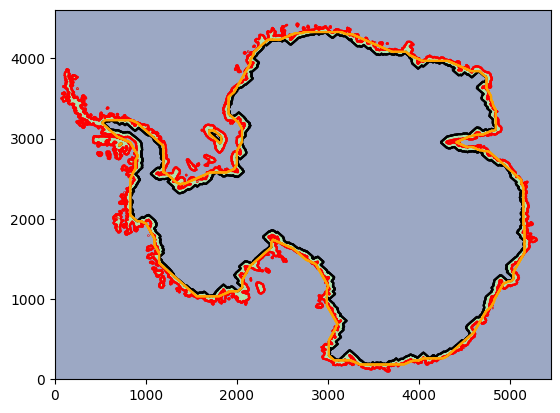

In [49]:
xmin,xmax,ymin,ymax=500,1500,1500,2300
# get the diff mask
mask_r=(~ np.isnan(c_retreat)).astype('int')
mask_gr=(~ np.isnan(gr)).astype('int')
mask_fl=(~ np.isnan(c_floating)).astype('int')

mask_diff = mask_gr -mask_r
f,ax = plt.subplots(1,1)
ax.contourf(d.x,d.y,mask_diff,origin ='lower',alpha = 0.5,levels=[-0.5,0.5,1.5] )

ax.contour(d.x,d.y,np.isnan(c_retreat).astype('int'),origin ='lower',alpha = 0.5,colors = 'black' )
ax.contour(d.x,d.y,np.isnan(gr).astype('int'),origin ='lower',alpha = 0.5,colors = 'red')
ax.contour(d.x,d.y,np.isnan(c_floating).astype('int'),origin ='lower',alpha = 0.5,colors = 'orange')
         
# ax.set_xlim([xmin,xmax])
# ax.set_ylim([ymin,ymax])

In [42]:
np.unique(notnans)

array([1., 2., 3., 4., 5.])

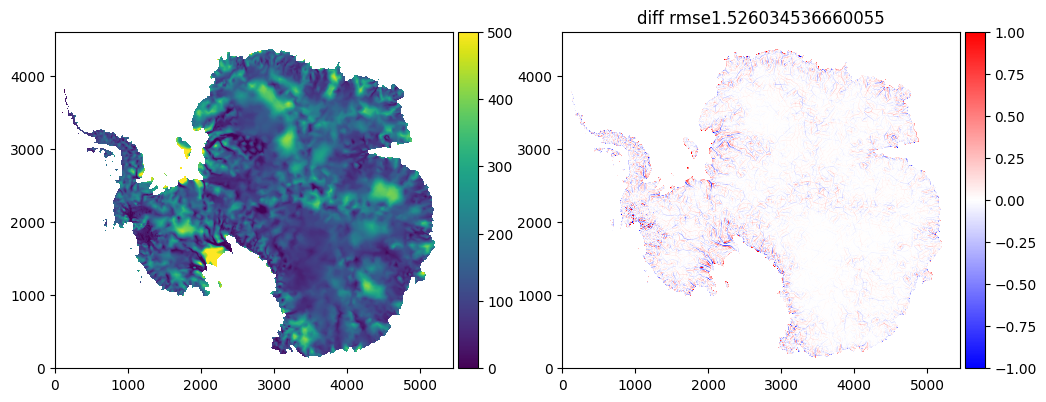

In [24]:

f,ax = plt.subplots(1,2,figsize = (12,12))

im =ax[0].imshow(gr,origin ='lower',vmin=0,vmax=500,)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
diff = gr-friction_nn
mn = np.isnan(diff)
vmin =np.nanmin(diff)
vmax =np.nanmax(diff)

rmse = (np.mean(diff[~mn]**2))**0.5

im2 =ax[1].imshow(diff,origin ='lower',vmin = -1,vmax =1, cmap = mpl.colormaps['bwr'])
ax[1].set_title('diff rmse'+ str(rmse))

divider2 = make_axes_locatable(ax[1])
cax2 = divider2.append_axes('right', size='5%', pad=0.05)

f.colorbar(im2, cax=cax2, orientation='vertical')
f.colorbar(im, cax=cax, orientation='vertical')

### nearest neighbour interpolation - ANALYSE

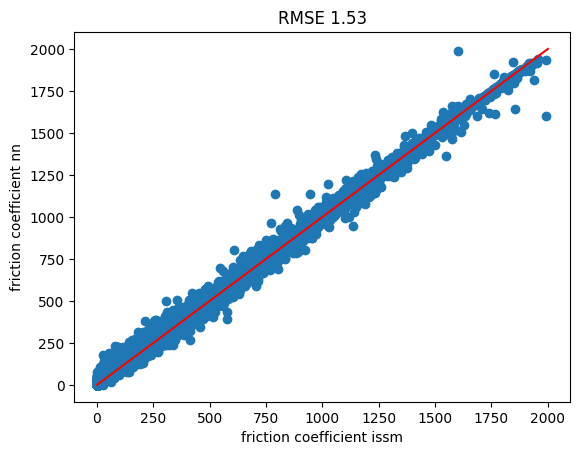

In [25]:
f,ax = plt.subplots(1,1)
ax.set_xlabel('friction coefficient issm')
ax.set_ylabel('friction coefficient nn')
c_real = gr
c_sim =friction_nn
rmse = (np.nanmean((c_real-c_sim)**2))**0.5
rmse_tit = np.round(rmse,2)
ax.set_title("RMSE "+str(rmse_tit))
ax.scatter(c_real,c_sim)
ax.plot([0,2000],[0,2000], color ='red')

#### nearest neighbour interpolation seems to gives us good values. but still some outliers although probably no nan values for averagin. How does that look at the border i.e. grounding line cells

## check boarder values

First get boarder values by shiftin grid an lookinf for nans

In [26]:
mask=(~ np.isnan(gr)).astype('int')
boarder_mask = border_cell_on_icesheet(mask)
# plt.contour(boarder_mask,origin = 'lower')

### RMSE increases on  last grounded cells, probably because nans es nearest neighbours

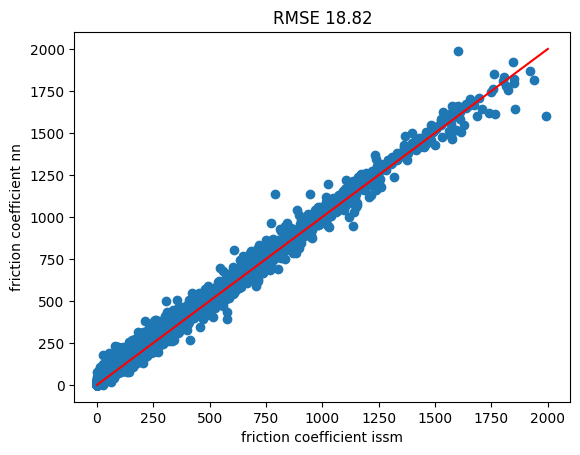

In [27]:
f,ax = plt.subplots(1,1)
ax.set_xlabel('friction coefficient issm')
ax.set_ylabel('friction coefficient nn')

c_real = gr[boarder_mask.astype('bool')]
c_sim =friction_nn[boarder_mask.astype('bool')]
rmse = (np.nanmean((c_real-c_sim)**2))**0.5
rmse_tit = np.round(rmse,2)
ax.set_title("RMSE "+str(rmse_tit))
ax.scatter(c_real,c_sim)
ax.plot([0,2000],[0,2000], color ='red')

In [28]:
c_real_boarder = gr.copy()
c_sim_boarder =friction_nn.copy()
c_real_boarder[~boarder_mask.astype('bool')]=np.nan
c_sim_boarder[~boarder_mask.astype('bool')]=np.nan

In [31]:
bed_boarder = bd.copy()
bed_boarder[~boarder_mask.astype('bool')]=np.nan

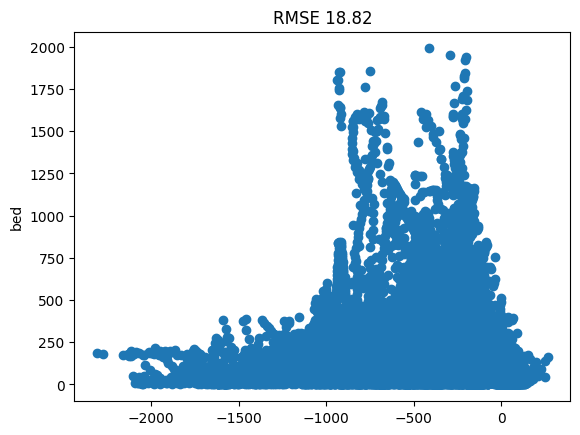

In [32]:
f,ax = plt.subplots(1,1)
ax.set_ylabel('friction coefficient issm')
ax.set_ylabel('bed')


# rmse = (np.nanmean((c_real-c_sim)**2))**0.5
# rmse_tit = np.round(rmse,2)
ax.set_title("RMSE "+str(rmse_tit))
ax.scatter(bed_boarder ,c_real_boarder)
# ax.plot([0,2000],[0,2000], color ='red')

## Basin wide/

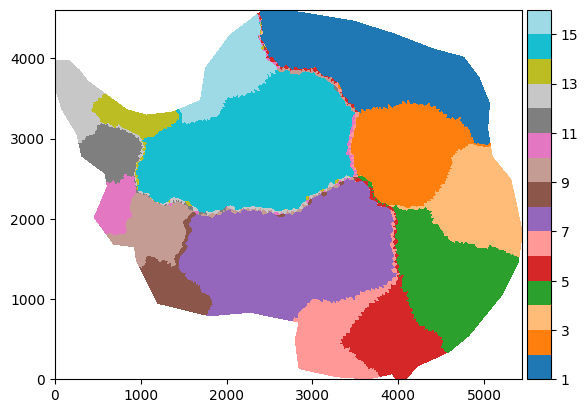

In [34]:
f,ax = plt.subplots(1,1)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im =ax.contourf(d3.x,d3.y,d3['basin'].values,levels =16,cmap ='tab20')


f.colorbar(im, cax=cax, orientation='vertical')

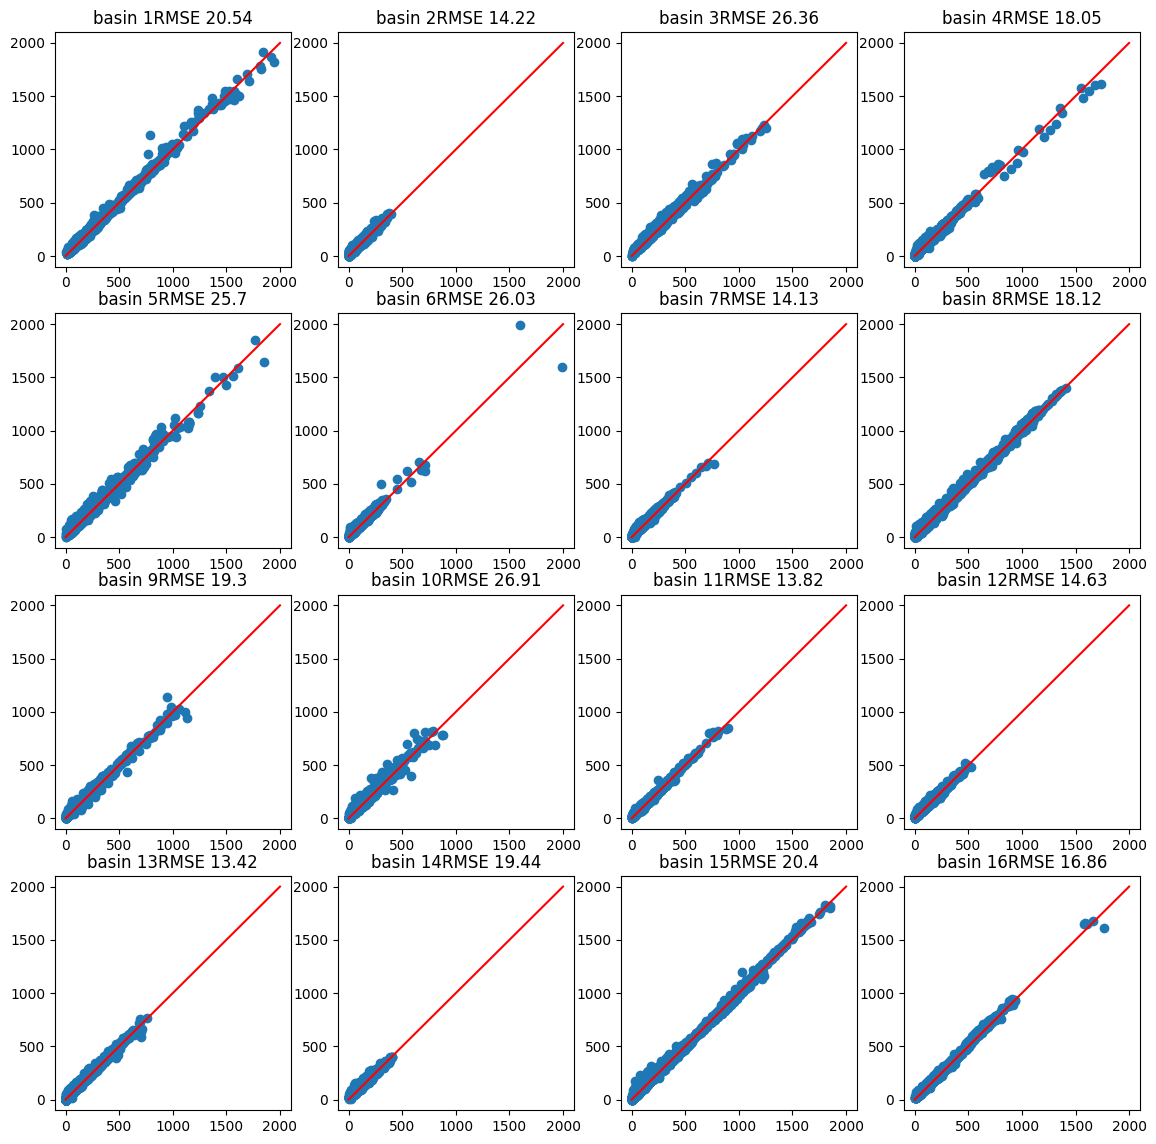

In [35]:
f, ax = plt.subplots(4,4,figsize =(14,14))
for b in range(16):
    i =b//4
    j = b%4
    b =b+1
    m_b = d3['basin'].values ==float(b) 
    c_real = c_real_boarder[m_b]
    c_sim =c_sim_boarder[m_b]
    rmse = (np.nanmean((c_real-c_sim)**2))**0.5
    rmse_tit = np.round(rmse,2)
    ax[i,j].set_title('basin '+str(b) +'RMSE '+str(rmse_tit))
    ax[i,j].scatter(c_real,c_sim)
    ax[i,j].plot([0,2000],[0,2000], color ='red')



## bedtype wide ?

In [36]:
bedtype = d7['bedtype'].values.copy()
bedtype[ bedtype <-4] = np.nan
bedtype = bedtype.astype('int')


/var/folders/ph/m61jd3r90t190p6qvbps3yqct2hr65/T/ipykernel_60573/3603056879.py:3: RuntimeWarning: invalid value encountered in cast
  bedtype = bedtype.astype('int')


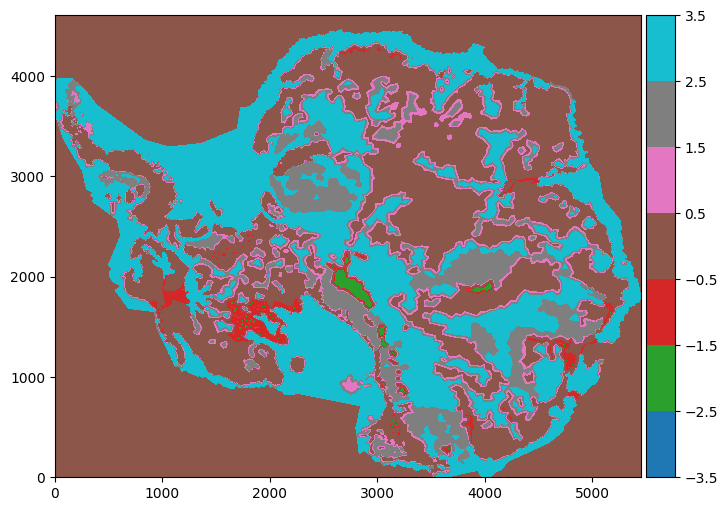

In [37]:
f,ax = plt.subplots(1,1,figsize = (8,6))

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
bedtype_values = np.unique(bedtype)
levels = list(bedtype_values  -0.5)
levels.append(bedtype_values [-1]+0.5)

im =ax.contourf( d7.x,d7.y,bedtype,levels =levels,cmap ='tab10')
# im =ax.imshow(geotiff_ds['from'])
cbar1=f.colorbar(im, cax=cax, orientation='vertical')

/var/folders/ph/m61jd3r90t190p6qvbps3yqct2hr65/T/ipykernel_60573/4226676381.py:27: RuntimeWarning: Mean of empty slice
  rmse = (np.nanmean((c_real-c_sim)**2))**0.5


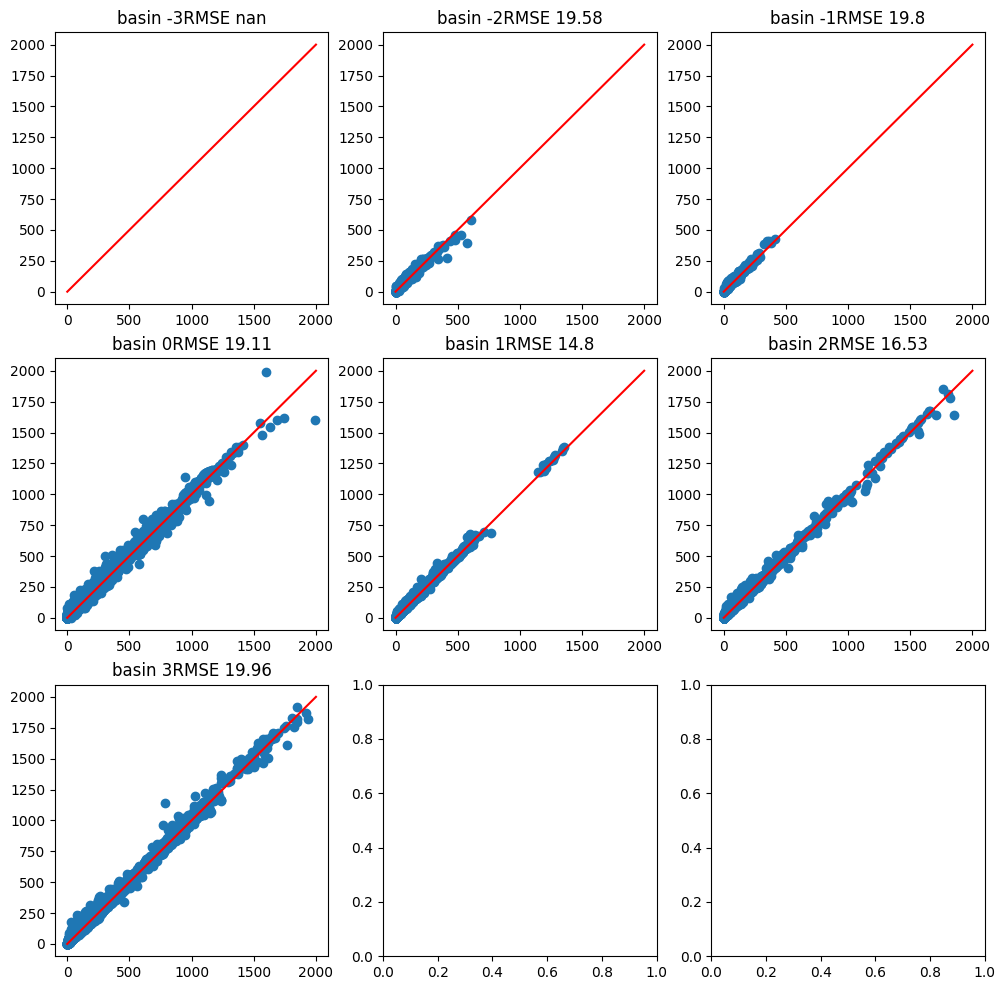

In [38]:
f, ax = plt.subplots(3,3,figsize =(12,12))
for b,val in enumerate(bedtype_values):
    i =b//3
    j = b%3
    b =b+1
    m_b = bedtype ==val
    dic ={}
#     dic['coefficient']= gr[ m_b]
#     dic['bed']=bd[ m_b]
#     dic['slope']=slopes_angle_ana[ m_b]
#     dic['gth']=gth[ m_b]
    
    ds = pd.DataFrame.from_dict(dic)
    ds =ds.dropna()
#     y = ds['coefficient']
#     X = ds[['bed', 'slope','gth']]

    
#     X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.3, random_state=101)
#     model = LinearRegression()
#     model.fit(X_train,y_train)
#     predictions = model.predict(X_test)

    c_real = c_real_boarder[m_b]
    c_sim =c_sim_boarder[m_b]
    rmse = (np.nanmean((c_real-c_sim)**2))**0.5
    rmse_tit = np.round(rmse,2)
    ax[i,j].set_title('basin '+str(val) +'RMSE '+str(rmse_tit))
    ax[i,j].scatter(c_real,c_sim)
    ax[i,j].plot([0,2000],[0,2000], color ='red')

  


## Now can we reduce the RMSE with nearest neihgbour and e physical function of the bed? (z, slope, bedtype, )???

at the boarder...`

In [39]:
    dic ={}
    gth = d6['geothermalflux'].values.copy()
    dic['coefficient']= c_real_boarder[boarder_mask.astype('bool')]
    dic['sim_coefficient']= c_sim_boarder[boarder_mask.astype('bool')]
    
    dic['bed']=bd[boarder_mask.astype('bool')]
    dic['slope']=slopes_angle_ana[ boarder_mask.astype('bool')]
    dic['gth']=gth[boarder_mask.astype('bool')]
    
    ds = pd.DataFrame.from_dict(dic)
    ds =ds.dropna()
#     y = ds['coefficient']
#     X = ds[['bed', 'slope','gth']]

    
#     X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.3, random_state=101)
#     model = LinearRegression()
#     model.fit(X_train,y_train)
#     predictions = model.predict(X_test)

use frist all groundedn cells

mean_squared_error :  210.69302337404096
mean_absolute_error :  9.647263886687707


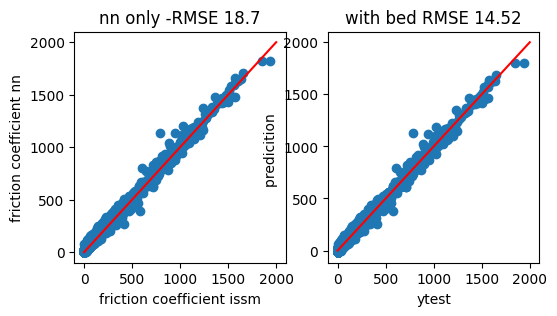

In [40]:
y = ds['coefficient']
X = ds[['sim_coefficient','slope']]

    
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.3, random_state=101)
model = LinearRegression()
model.fit(X_train,y_train)
predictions = model.predict(X_test) 

# model evaluation
print(
'mean_squared_error : ', mean_squared_error(y_test, predictions))
print(
'mean_absolute_error : ', mean_absolute_error(y_test, predictions))

f,ax = plt.subplots(1,2,figsize = (6,3))

ax[0].set_xlabel('friction coefficient issm')
ax[0].set_ylabel('friction coefficient nn')

c_real = y_test.values
c_sim =X_test.sim_coefficient.values
rmse = (np.nanmean((c_real-c_sim)**2))**0.5
rmse_tit = np.round(rmse,2)
ax[0].set_title("nn only -RMSE "+str(rmse_tit))
ax[0].scatter(c_real,c_sim)
ax[0].plot([0,2000],[0,2000], color ='red')

ax[1].set_xlabel('ytest')
ax[1].set_ylabel('predicition ')

c_real = y_test
c_sim =predictions
rmse = (np.nanmean((c_real-c_sim)**2))**0.5
rmse_tit = np.round(rmse,2)
ax[1].set_title("with bed RMSE "+str(rmse_tit))
ax[1].scatter(c_real,c_sim)
ax[1].plot([0,2000],[0,2000], color ='red')

mean_squared_error :  210.3300853271087
mean_absolute_error :  9.627931169496765


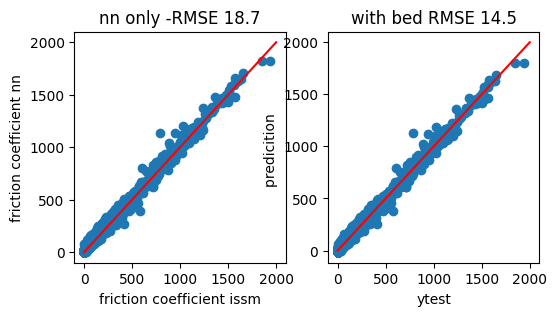

In [41]:
y = ds['coefficient']
X = ds[['sim_coefficient','bed','slope','gth']]

    
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.3, random_state=101)
model = LinearRegression()
model.fit(X_train,y_train)
predictions = model.predict(X_test) 

# model evaluation
print(
'mean_squared_error : ', mean_squared_error(y_test, predictions))
print(
'mean_absolute_error : ', mean_absolute_error(y_test, predictions))

f,ax = plt.subplots(1,2,figsize = (6,3))

ax[0].set_xlabel('friction coefficient issm')
ax[0].set_ylabel('friction coefficient nn')

c_real = y_test.values
c_sim =X_test.sim_coefficient.values
rmse = (np.nanmean((c_real-c_sim)**2))**0.5
rmse_tit = np.round(rmse,2)
ax[0].set_title("nn only -RMSE "+str(rmse_tit))
ax[0].scatter(c_real,c_sim)
ax[0].plot([0,2000],[0,2000], color ='red')

ax[1].set_xlabel('ytest')
ax[1].set_ylabel('predicition ')

c_real = y_test
c_sim =predictions
rmse = (np.nanmean((c_real-c_sim)**2))**0.5
rmse_tit = np.round(rmse,2)
ax[1].set_title("with bed RMSE "+str(rmse_tit))
ax[1].scatter(c_real,c_sim)
ax[1].plot([0,2000],[0,2000], color ='red')

 ###  above  sea level?

In [42]:
    dic ={}
    m_negbed = bd < 0
    c_real_boarder1= c_real_boarder.copy()
    c_sim_boarder1=c_sim_boarder.copy()
    bd1 =  bd.copy()
    slopes_angle_ana1 = slopes_angle_ana.copy()
    gth1 =gth.copy()
    c_real_boarder1[m_negbed]=np.nan
    c_sim_boarder1[m_negbed]=np.nan
    bd1[m_negbed]=np.nan
    slopes_angle_ana1[m_negbed]=np.nan
    gth1[m_negbed]=np.nan
    
    
    gth = d6['geothermalflux'].values.copy()
    dic['coefficient']= c_real_boarder1[boarder_mask.astype('bool')]
    dic['sim_coefficient']= c_sim_boarder1[boarder_mask.astype('bool')]
    
    dic['bed']=bd1[boarder_mask.astype('bool')]
    dic['slope']=slopes_angle_ana1[ boarder_mask.astype('bool')]
    dic['gth']=gth1[boarder_mask.astype('bool')]
    
    dic_belwosl=dic
    
    ds = pd.DataFrame.from_dict(dic)
    ds =ds.dropna()
#     y = ds['coefficient']
#     X = ds[['bed', 'slope','gth']]

    
#     X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.3, random_state=101)
#     model = LinearRegression()
#     model.fit(X_train,y_train)
#     predictions = model.predict(X_test)

use frist all groundedn cells

mean_squared_error :  52.49266631006527
mean_absolute_error :  4.122803575052125


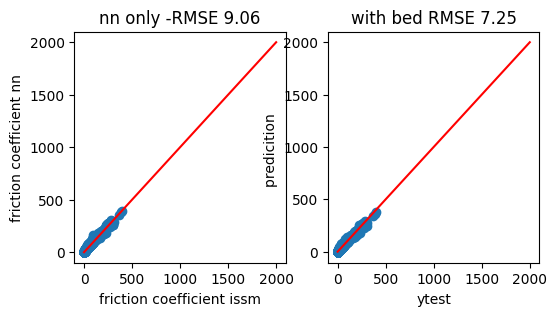

In [43]:
y = ds['coefficient']
X = ds[['sim_coefficient','slope']]

    
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.3, random_state=101)
model = LinearRegression()
model.fit(X_train,y_train)
predictions = model.predict(X_test) 

# model evaluation
print(
'mean_squared_error : ', mean_squared_error(y_test, predictions))
print(
'mean_absolute_error : ', mean_absolute_error(y_test, predictions))

f,ax = plt.subplots(1,2,figsize = (6,3))

ax[0].set_xlabel('friction coefficient issm')
ax[0].set_ylabel('friction coefficient nn')

c_real = y_test.values
c_sim =X_test.sim_coefficient.values
rmse = (np.nanmean((c_real-c_sim)**2))**0.5
rmse_tit = np.round(rmse,2)
ax[0].set_title("nn only -RMSE "+str(rmse_tit))
ax[0].scatter(c_real,c_sim)
ax[0].plot([0,2000],[0,2000], color ='red')

ax[1].set_xlabel('ytest')
ax[1].set_ylabel('predicition ')

c_real = y_test
c_sim =predictions
rmse = (np.nanmean((c_real-c_sim)**2))**0.5
rmse_tit = np.round(rmse,2)
ax[1].set_title("with bed RMSE "+str(rmse_tit))
ax[1].scatter(c_real,c_sim)
ax[1].plot([0,2000],[0,2000], color ='red')

mean_squared_error :  50.284521718983
mean_absolute_error :  4.055170931397643


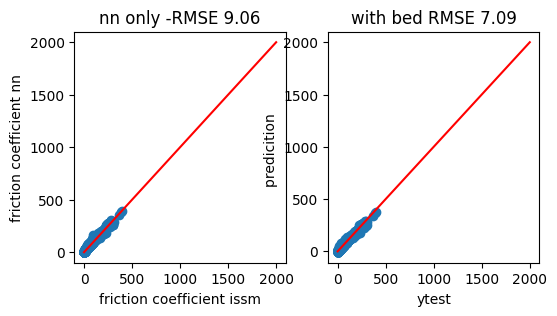

In [46]:
y = ds['coefficient']
X = ds[['sim_coefficient','bed','slope','gth']]

    
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.3, random_state=101)
model = LinearRegression()
model.fit(X_train,y_train)
predictions = model.predict(X_test) 

# model evaluation
print(
'mean_squared_error : ', mean_squared_error(y_test, predictions))
print(
'mean_absolute_error : ', mean_absolute_error(y_test, predictions))

f,ax = plt.subplots(1,2,figsize = (6,3))

ax[0].set_xlabel('friction coefficient issm')
ax[0].set_ylabel('friction coefficient nn')

c_real = y_test.values
c_sim =X_test.sim_coefficient.values
rmse = (np.nanmean((c_real-c_sim)**2))**0.5
rmse_tit = np.round(rmse,2)
ax[0].set_title("nn only -RMSE "+str(rmse_tit))
ax[0].scatter(c_real,c_sim)
ax[0].plot([0,2000],[0,2000], color ='red')

ax[1].set_xlabel('ytest')
ax[1].set_ylabel('predicition ')

c_real = y_test
c_sim =predictions
rmse = (np.nanmean((c_real-c_sim)**2))**0.5
rmse_tit = np.round(rmse,2)
ax[1].set_title("with bed RMSE "+str(rmse_tit))
ax[1].scatter(c_real,c_sim)
ax[1].plot([0,2000],[0,2000], color ='red')

### for below seal level

In [47]:
    dic ={}
    gth = d6['geothermalflux'].values.copy()
    
    m_negbed = bd > 0
    c_real_boarder1= c_real_boarder.copy()
    c_sim_boarder1=c_sim_boarder.copy()
    bd1 =  bd.copy()
    slopes_angle_ana1 = slopes_angle_ana.copy()
    gth1 =gth.copy()
    c_real_boarder1[m_negbed]=np.nan
    c_sim_boarder1[m_negbed]=np.nan
    bd1[m_negbed]=np.nan
    slopes_angle_ana1[m_negbed]=np.nan
    gth1[m_negbed]=np.nan
    
    
    dic['coefficient']= c_real_boarder1[boarder_mask.astype('bool')]
    dic['sim_coefficient']= c_sim_boarder1[boarder_mask.astype('bool')]
    
    dic['bed']=bd1[boarder_mask.astype('bool')]
    dic['slope']=slopes_angle_ana1[ boarder_mask.astype('bool')]
    dic['gth']=gth1[boarder_mask.astype('bool')]
    
    ds = pd.DataFrame.from_dict(dic)
    ds =ds.dropna()
    dic_abovesl=dic
#     y = ds['coefficient']
#     X = ds[['bed', 'slope','gth']]

    
#     X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.3, random_state=101)
#     model = LinearRegression()
#     model.fit(X_train,y_train)
#     predictions = model.predict(X_test)

use frist all groundedn cells

mean_squared_error :  249.44195189277252
mean_absolute_error :  10.205232562261576


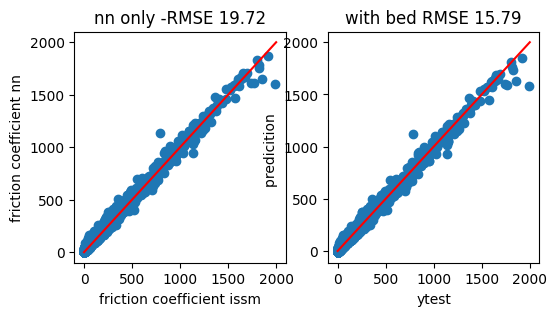

In [50]:
y = ds['coefficient']
X = ds[['sim_coefficient','bed']]

    
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.3, random_state=101)
model = LinearRegression()
model.fit(X_train,y_train)
predictions = model.predict(X_test) 

# model evaluation
print(
'mean_squared_error : ', mean_squared_error(y_test, predictions))
print(
'mean_absolute_error : ', mean_absolute_error(y_test, predictions))

f,ax = plt.subplots(1,2,figsize = (6,3))

ax[0].set_xlabel('friction coefficient issm')
ax[0].set_ylabel('friction coefficient nn')

c_real = y_test.values
c_sim =X_test.sim_coefficient.values
rmse = (np.nanmean((c_real-c_sim)**2))**0.5
rmse_tit = np.round(rmse,2)
ax[0].set_title("nn only -RMSE "+str(rmse_tit))
ax[0].scatter(c_real,c_sim)
ax[0].plot([0,2000],[0,2000], color ='red')

ax[1].set_xlabel('ytest')
ax[1].set_ylabel('predicition ')

c_real = y_test
c_sim =predictions
rmse = (np.nanmean((c_real-c_sim)**2))**0.5
rmse_tit = np.round(rmse,2)
ax[1].set_title("with bed RMSE "+str(rmse_tit))
ax[1].scatter(c_real,c_sim)
ax[1].plot([0,2000],[0,2000], color ='red')

mean_squared_error :  241.1968894788826
mean_absolute_error :  9.88697852777185


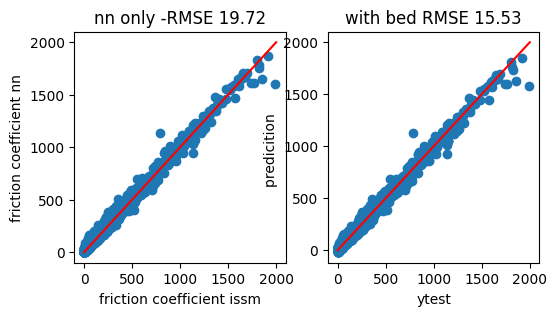

In [49]:
y = ds['coefficient']
X = ds[['sim_coefficient','bed','slope','gth']]

    
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.3, random_state=101)
model = LinearRegression()
model.fit(X_train,y_train)
predictions = model.predict(X_test) 

# model evaluation
print(
'mean_squared_error : ', mean_squared_error(y_test, predictions))
print(
'mean_absolute_error : ', mean_absolute_error(y_test, predictions))

f,ax = plt.subplots(1,2,figsize = (6,3))

ax[0].set_xlabel('friction coefficient issm')
ax[0].set_ylabel('friction coefficient nn')

c_real = y_test.values
c_sim =X_test.sim_coefficient.values
rmse = (np.nanmean((c_real-c_sim)**2))**0.5
rmse_tit = np.round(rmse,2)
ax[0].set_title("nn only -RMSE "+str(rmse_tit))
ax[0].scatter(c_real,c_sim)
ax[0].plot([0,2000],[0,2000], color ='red')

ax[1].set_xlabel('ytest')
ax[1].set_ylabel('predicition ')

c_real = y_test
c_sim =predictions
rmse = (np.nanmean((c_real-c_sim)**2))**0.5
rmse_tit = np.round(rmse,2)
ax[1].set_title("with bed RMSE "+str(rmse_tit))
ax[1].scatter(c_real,c_sim)
ax[1].plot([0,2000],[0,2000], color ='red')

### Bed type for below se;a 

In [137]:
dic_belwosl

{'coefficient': array([nan, nan, nan, ..., nan, nan, nan]),
 'sim_coefficient': array([nan, nan, nan, ..., nan, nan, nan]),
 'bed': array([nan, nan, nan, ..., nan, nan, nan]),
 'slope': array([nan, nan, nan, ..., nan, nan, nan]),
 'gth': array([nan, nan, nan, ..., nan, nan, nan])}

In [146]:
len(ds)

0

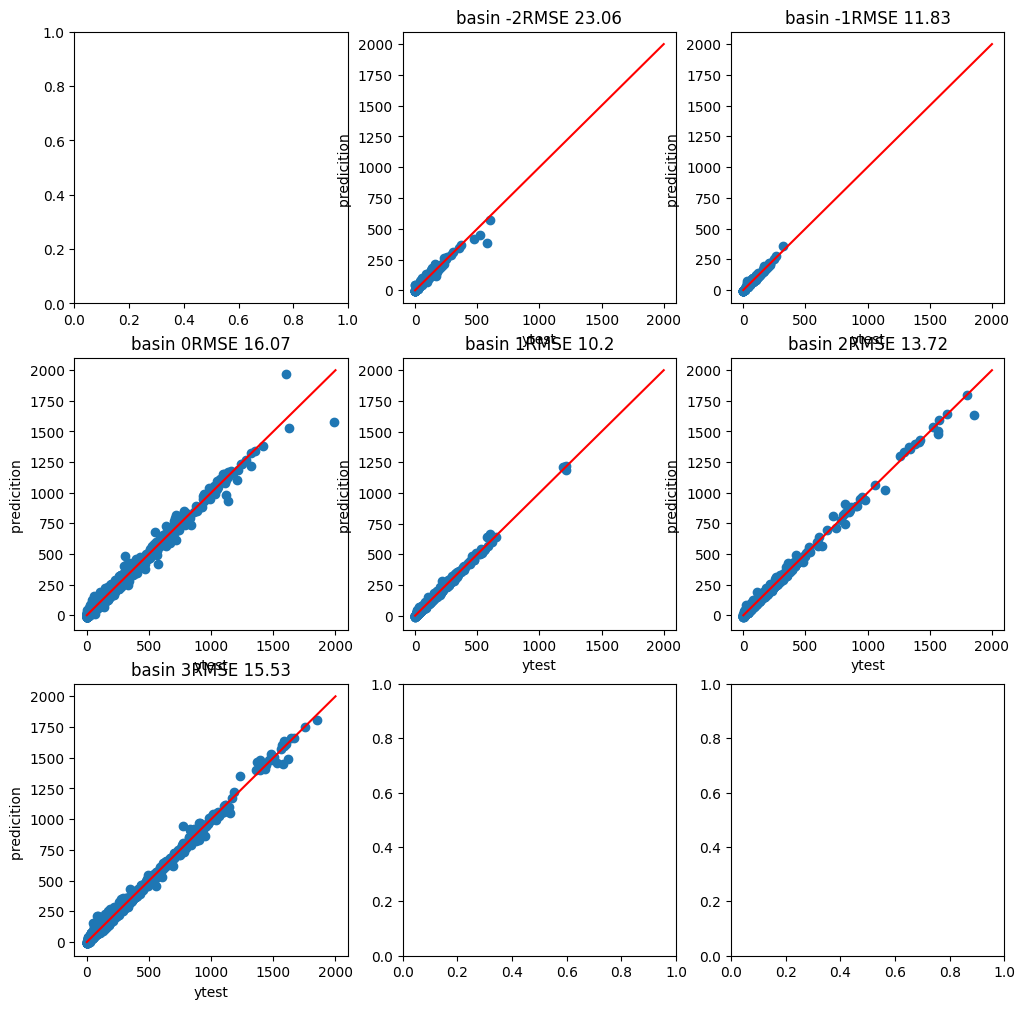

In [150]:
f, ax = plt.subplots(3,3,figsize =(12,12))
for b,val in enumerate(bedtype_values):
    i =b//3
    j = b%3
    b =b+1
    m_negbed = bedtype !=val
    dic ={}
 
    gth = d6['geothermalflux'].values.copy()
    
    c_real_boarder1= c_real_boarder.copy()
    c_sim_boarder1=c_sim_boarder.copy()
    bd1 =  bd.copy()
    slopes_angle_ana1 = slopes_angle_ana.copy()
    gth1 =gth.copy()
    c_real_boarder1[m_negbed]=np.nan
    c_sim_boarder1[m_negbed]=np.nan
    bd1[m_negbed]=np.nan
    slopes_angle_ana1[m_negbed]=np.nan
    gth1[m_negbed]=np.nan
    
    
    dic['coefficient']= c_real_boarder1[boarder_mask.astype('bool')]
    dic['sim_coefficient']= c_sim_boarder1[boarder_mask.astype('bool')]
    
    dic['bed']=bd1[boarder_mask.astype('bool')]
    dic['slope']=slopes_angle_ana1[ boarder_mask.astype('bool')]
    dic['gth']=gth1[boarder_mask.astype('bool')]
    
    ds = pd.DataFrame.from_dict(dic)
    ds =ds.dropna()
    y = ds['coefficient']
    X = ds[['sim_coefficient','bed']]

    if len(ds)==0:
        continue
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=101)
    model = LinearRegression()
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    

    ax[i,j].set_xlabel('ytest')
    ax[i,j].set_ylabel('predicition ')

    c_real = y_test
    c_sim =predictions
    rmse = (np.nanmean((c_real-c_sim)**2))**0.5
    rmse_tit = np.round(rmse,2)
    
    ax[i,j].set_title('basin '+str(val) +'RMSE '+str(rmse_tit))
    ax[i,j].scatter(c_real,c_sim)
    ax[i,j].plot([0,2000],[0,2000], color ='red')

  


### basin wide 

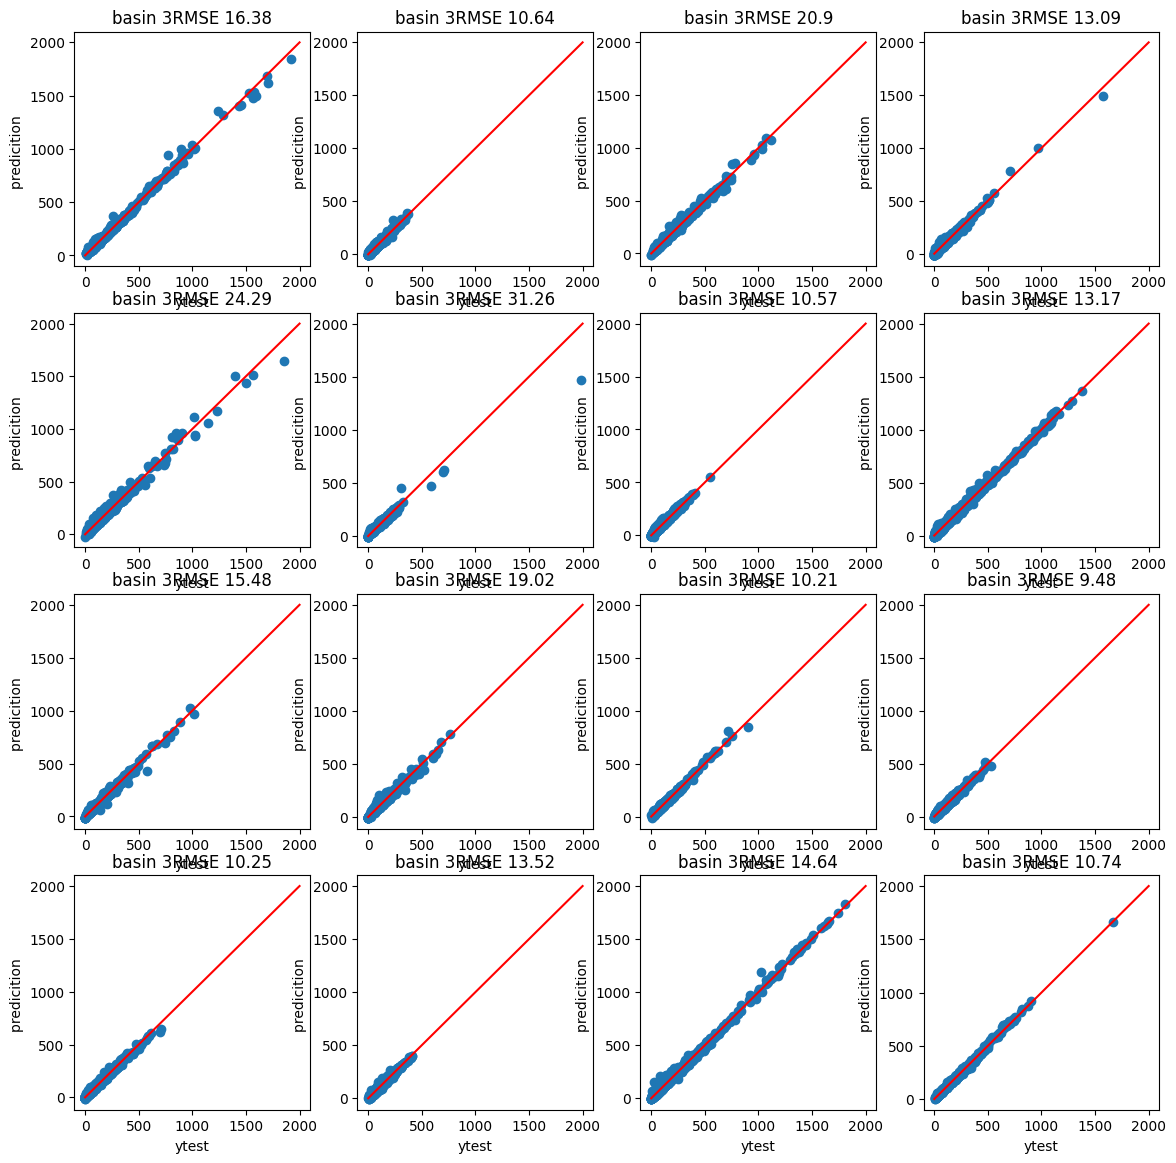

In [151]:
f, ax = plt.subplots(4,4,figsize =(14,14))
for b in range(16):
    i =b//4
    j = b%4
    b =b+1
    m_negbed= d3['basin'].values !=float(b) 
  
    dic ={}
 
    gth = d6['geothermalflux'].values.copy()
    
    c_real_boarder1= c_real_boarder.copy()
    c_sim_boarder1=c_sim_boarder.copy()
    bd1 =  bd.copy()
    slopes_angle_ana1 = slopes_angle_ana.copy()
    gth1 =gth.copy()
    c_real_boarder1[m_negbed]=np.nan
    c_sim_boarder1[m_negbed]=np.nan
    bd1[m_negbed]=np.nan
    slopes_angle_ana1[m_negbed]=np.nan
    gth1[m_negbed]=np.nan
    
    
    dic['coefficient']= c_real_boarder1[boarder_mask.astype('bool')]
    dic['sim_coefficient']= c_sim_boarder1[boarder_mask.astype('bool')]
    
    dic['bed']=bd1[boarder_mask.astype('bool')]
    dic['slope']=slopes_angle_ana1[ boarder_mask.astype('bool')]
    dic['gth']=gth1[boarder_mask.astype('bool')]
    
    ds = pd.DataFrame.from_dict(dic)
    ds =ds.dropna()
    
    

    y = ds['coefficient']
    X = ds[['sim_coefficient','bed']]
    if len(ds)==0:
        continue
        
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=101)
    model = LinearRegression()
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    ax[i,j].set_xlabel('ytest')
    ax[i,j].set_ylabel('predicition ')

    c_real = y_test
    c_sim =predictions
    rmse = (np.nanmean((c_real-c_sim)**2))**0.5
    rmse_tit = np.round(rmse,2)
    
    ax[i,j].set_title('basin '+str(b) +'RMSE '+str(rmse_tit))
    ax[i,j].scatter(c_real,c_sim)
    ax[i,j].plot([0,2000],[0,2000], color ='red')
  


  ##### Dividing in into below and above sea level or by different bedrock type still gives me high RMSE and does not improve the RMSE siginificantly. Creating fucntion with multiple regression ob bedrock depth slope and geothermal heat flux all very little imrpovement,if overall, thus we will just derive a model only from the nn mean values!

In [219]:
dic ={}
gth = d6['geothermalflux'].values.copy()
dic['coefficient']= c_real_boarder[boarder_mask.astype('bool')]
dic['sim_coefficient']= c_sim_boarder[boarder_mask.astype('bool')]
    
dic['bed']=bd[boarder_mask.astype('bool')]
dic['slope']=slopes_angle_ana[ boarder_mask.astype('bool')]
dic['gth']=gth[boarder_mask.astype('bool')]
    
ds = pd.DataFrame.from_dict(dic)
ds =ds.dropna()

seeds = np.linspace(1,1000,1000).astype('int')


In [198]:
from sklearn.linear_model import Ridge

In [242]:

rmses = np.zeros(len(seeds))
intercepts = np.zeros(len(seeds))
cnn_fac = np.zeros(len(seeds))
bed_fac = np.zeros(len(seeds))
slope_fac = np.zeros(len(seeds))



for i,ss in enumerate(seeds):

    y = ds['coefficient']
    X = ds[['sim_coefficient','bed','slope']]


    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=ss)
    model = LinearRegression()
#     model = Ridge(alpha = 10)
    
    model.fit(X_train,y_train)
    predictions = model.predict(X_test) 

 
    c_real = y_test
    c_sim =predictions
    rmse = (np.nanmean((c_real-c_sim)**2))**0.5
    rmse_tit = np.round(rmse,2)
    rmses[i]=rmse_tit
    intercepts[i]=model.intercept_
    cnn_fac[i]=model.coef_[0]
    bed_fac[i]=model.coef_[1]
    slope_fac[i]=model.coef_[2]
    
    
    # ax[1].set_title("with bed RMSE "+str(rmse_tit))
    # ax[1].scatter(c_real,c_sim)
    # ax[1].plot([0,2000],[0,2000], color ='red')
print('rmse mean',rmses.mean() )

rmse mean 14.69728


In [247]:
int_cnn = intercepts.mean()
fac_cnn = cnn_fac.mean()
dic_fn = {}
dic_fn['intercept'] = int_cnn
dic_fn['slope'] = fac_cnn
dic_fn['slope_bed'] = bed_fac.mean()
dic_fn['slope_slope'] = slope_fac.mean()


np.save('./../Data/Fields/my_function_friction_cnn_sim_coefficient_bed_slope.npy',dic_fn)

In [225]:
X.keys()

Index(['sim_coefficient'], dtype='object')

In [222]:
dic.keys()

dict_keys(['coefficient', 'sim_coefficient', 'bed', 'slope', 'gth'])

In [218]:
int_cnn

-10.739751931853226

In [209]:
model_final_fun(c_nn):


In [210]:
model_final.coe

LinearRegression()


mean only =rmse mean 14.95 //
bed rmse mean 14.942459999999999 //
slope rmse mean 14.70079000 //
gth rmse mean 14.95234 //

In [196]:
LinearRegression?

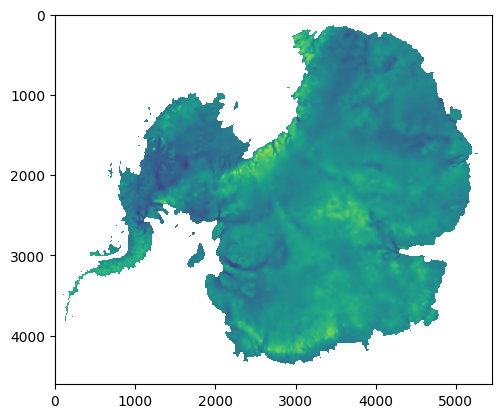

In [249]:
plt.imshow(bd)

In [206]:
model.coef_

array([0.99710811, 0.00218976])

In [207]:
model.intercept_

-10.09123457385789

In [171]:
y_test.iloc[0]


242.74981950224594

In [175]:
X_test.sim_coefficient.iloc[0]*model.coef_[0]+X_test.bed.iloc[0]*model.coef_[1] + model.intercept_

235.00031874521042

In [176]:
predictions

array([235.00031875,  38.94517925,  96.62257219, ..., 133.59728593,
       112.41207193, 192.16043621])

#### let us calclulate the coeff from a mean of the neighbours